In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib

In [2]:
np.random.seed(666)

K = 10 # Number of blobs
l = -6
u = -l
Blob_centers = np.random.uniform(l, u, size=(K, 2))

Blob_variance = 0.125
samp_per_blob = 200 # this was 50 in the first try
D = []
for k in range(K):
    D.append(np.random.multivariate_normal(Blob_centers[k,:], Blob_variance*np.identity(2), size=samp_per_blob))
Dlist = D
D = np.array(D) # distributed data

X = np.reshape(D, (D.shape[0]*D.shape[1], D.shape[2])) # centralized data

## Model and analyitic solution

Assume the model:
\begin{align}
    &x_1, \ldots, x_N | \mu\sim \mathcal{N}(\mu, I)\\
    & \mu_0, \mu_1 \sim \mathcal{N}(0, 5),
\end{align}
which has analytical posterior:
\begin{equation}
    p(\mu \,|\, x_1, \ldots, x_N) = \mathcal{N}\Bigg(\frac{\sum_i x_i}{N + 0.2} , \frac{1}{N + 0.2} I \Bigg)
\end{equation}

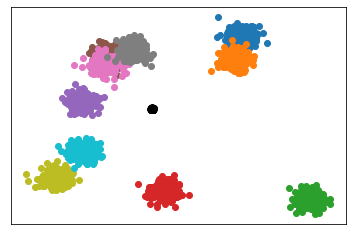

In [3]:
analytic_mu = np.sum(X, axis=0) / (X.shape[0] + 0.2)
analytic_cov = 1/(X.shape[0] + 0.2) * np.identity(2)
target = np.random.multivariate_normal(analytic_mu, analytic_cov, size=1000)

plt.figure(figsize=(6, 4))

for k in range(K):
    plt.scatter(D[k, :, 0], D[k, :, 1])


plt.gca().set_xticks([]) 
plt.gca().set_yticks([]) 

plt.scatter(target[:,0], target[:, 1], color='k')
plt.tick_params(labelsize=12)
plt.savefig('blob_posterior.png')
plt.show(block=False)

np.random.seed(123)

# Gradients for the log-prior and log-likelihood

In [4]:
def grad_log_prior(theta):
    return - 0.2 * theta

def grad_log_lik(X, theta):
    return np.sum(X, axis=0) - X.shape[0]*theta

## DSGLD

In [5]:
def DSGLD(D, eps, n, theta0, rounds, iter_per_round):
    K = len(D)
    N = 0
    samples = np.zeros(( int(rounds*iter_per_round), theta0.shape[0]))
    theta = theta0
    idx = 0
    for k in range(K):
        N += D[k].shape[0]
    
    for r in range(rounds):
        s = np.random.randint(low=0, high=K) # same prob. for all shards
        X = D[s]
        Ns = X.shape[0]
        for t in range(0, iter_per_round):
            mb_idxs = np.random.randint(0, Ns, size=n)
            x_mb = X[mb_idxs,:]
            
            eps_t = eps # learning rate
            np.random.seed(idx)
            eta = np.random.normal(0, np.sqrt(eps_t), size=(2,))  # Noise
            grad_log_post = grad_log_prior(theta) + K*Ns/n * grad_log_lik(x_mb, theta)  # N/n: scale correction
            delta = eps_t/2 * grad_log_post + eta
            theta = theta + delta

            samples[idx,:] = theta
            idx += 1
    return samples

# FSGLD (Our method)

In [6]:
# Compute conducive terms/local approximations
mu_local = []
cov_local = []
prec_local = []
for k in range(K):
    muk = np.mean(np.asarray(Dlist[k]), axis=0)
    covk = np.identity(2) / np.asarray(Dlist[k]).shape[0]
    preck = np.identity(2) * np.asarray(Dlist[k]).shape[0]
    mu_local.append(muk)
    cov_local.append(covk)
    prec_local.append(preck)

In [7]:
def FSGLD(D, eps, n, theta0, rounds, iter_per_round, mu_local, prec_local):
    K = len(D)
    N = 0
    samples = np.zeros(( int(rounds*iter_per_round), theta0.shape[0]))
    theta = theta0
    idx = 0
    for k in range(K):
        N += D[k].shape[0]
        
    for r in range(rounds):
        s = np.random.randint(low=0, high=K) # same prob. for all shards
        X = D[s]
        Ns = X.shape[0]
        for t in range(0, iter_per_round):
            q_theta = theta * 0
            for shard in range(K):
                q_theta += -(theta - mu_local[shard]) @ prec_local[shard]
            qt_theta = -(theta - mu_local[s]) @ prec_local[s]
            
            mb_idxs = np.random.randint(0, Ns, size=n)
            x_mb = X[mb_idxs,:]
            
            eps_t = eps # learning rate
            np.random.seed(idx)
            eta = np.random.normal(0, np.sqrt(eps_t), size=(2,))  # Noise
            grad_log_post = grad_log_prior(theta) + K*Ns/n * grad_log_lik(x_mb, theta)   # N/n: scale correction
            idk_term = q_theta - K*qt_theta
            grad_log_post += idk_term
            delta = eps_t/2 * grad_log_post + eta
            theta = theta + delta

            samples[idx,:] = theta
            idx += 1

    return samples



In [8]:
theta0 = np.zeros(2,) + 6   # initial param

eps = 1e-04
thin = int(1e02) # 1e02
burn = int(2e04)

DSGLD_1 = DSGLD(Dlist, eps=eps, n=10, theta0=theta0*0, rounds=80000, iter_per_round=1)   
DSGLD_10 = DSGLD(Dlist, eps=eps, n=10, theta0=theta0*0, rounds=4000, iter_per_round=20)    
DSGLD_100 = DSGLD(Dlist, eps=eps, n=10, theta0=theta0*0, rounds=400, iter_per_round=200)  


CG_1 = FSGLD(Dlist, eps=eps, n=10, theta0=theta0*0, rounds=80000, iter_per_round=1,   mu_local=mu_local, prec_local=prec_local)    
CG_10 = FSGLD(Dlist, eps=eps, n=10, theta0=theta0*0, rounds=4000, iter_per_round=20,   mu_local=mu_local, prec_local=prec_local)    
CG_100 = FSGLD(Dlist, eps=eps, n=10, theta0=theta0*0, rounds=400, iter_per_round=200,   mu_local=mu_local, prec_local=prec_local)    

# Visualization of DSGLD and FSGLD samples

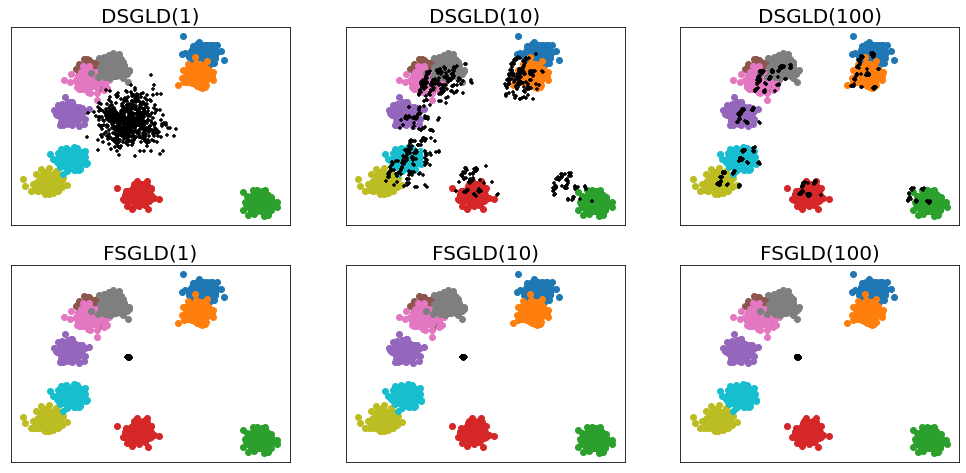

In [9]:
f, ax = plt.subplots(2, 3, sharey=True, figsize=(17, 8), sharex=True)

for k in range(K):
    ax[0, 0].scatter(D[k, :, 0], D[k, :, 1])
    ax[0, 1].scatter(D[k, :, 0], D[k, :, 1])
    ax[0, 2].scatter(D[k, :, 0], D[k, :, 1])
    ax[1, 0].scatter(D[k, :, 0], D[k, :, 1])
    ax[1, 1].scatter(D[k, :, 0], D[k, :, 1])
    ax[1, 2].scatter(D[k, :, 0], D[k, :, 1])
    
    ax[0, 0].set_xticks([])
    ax[0, 0].set_yticks([])
    
    ax[0, 1].set_xticks([])
    ax[0, 1].set_yticks([])
    
    ax[0, 2].set_xticks([])
    ax[0, 2].set_yticks([])
    

    ax[1, 0].set_xticks([])
    ax[1, 0].set_yticks([])
    
    ax[1, 1].set_xticks([])
    ax[1, 1].set_yticks([])
    
    ax[1, 2].set_xticks([])
    ax[1, 2].set_yticks([])
    


ax[0, 0].scatter(DSGLD_1[burn::thin, 0], DSGLD_1[burn::thin, 1], color='k', marker='+', s=16)
ax[1, 0].scatter(CG_1[burn::thin, 0], CG_1[burn::thin, 1], color='k', marker='+', s=16)
ax[0, 0].set_title('DSGLD(1)', fontsize=20)
ax[1, 0].set_title('FSGLD(1)', fontsize=20)


ax[0, 1].scatter(DSGLD_10[burn::thin, 0], DSGLD_10[burn::thin, 1], color='k', marker='+', s=16)
ax[1, 1].scatter(CG_10[burn::thin, 0], CG_10[burn::thin, 1], color='k', marker='+', s=16)
ax[0, 1].set_title('DSGLD(10)', fontsize=20)
ax[1, 1].set_title('FSGLD(10)', fontsize=20)

ax[0, 2].scatter(DSGLD_100[burn::thin, 0], DSGLD_100[burn::thin, 1], color='k', marker='+', s=16)
ax[1, 2].scatter(CG_100[burn::thin, 0], CG_100[burn::thin, 1], color='k', marker='+', s=16)
ax[0, 2].set_title('DSGLD(100)', fontsize=20)
ax[1, 2].set_title('FSGLD(100)', fontsize=20)

ax[1, 2].tick_params(labelsize=12)
ax[0, 2].tick_params(labelsize=12)
ax[1, 1].tick_params(labelsize=12)
ax[0, 1].tick_params(labelsize=12)
ax[1, 0].tick_params(labelsize=12)
ax[0, 0].tick_params(labelsize=12)

# plt.tight_layout()
plt.savefig('blobs.png')
plt.show(block=False)


# MSE for both methods

In [11]:
DSGLD_1_MSE = pairwise_distances(DSGLD_1[::thin,:], np.reshape(analytic_mu, (1, analytic_mu.shape[0])))
CG_1_MSE = pairwise_distances(CG_1[::thin,:], np.reshape(analytic_mu, (1, analytic_mu.shape[0])))
DS1_CUM = np.zeros(DSGLD_1_MSE.shape)
CG1_CUM = np.zeros(DSGLD_1_MSE.shape)
for i in range(DS1_CUM.shape[0]):
    DS1_CUM[i] = np.mean(DSGLD_1_MSE[:(i+1)])
    CG1_CUM[i] = np.mean(CG_1_MSE[:(i+1)])

DSGLD_10_MSE = pairwise_distances(DSGLD_10[::thin,:], np.reshape(analytic_mu, (1, analytic_mu.shape[0])))
CG_10_MSE = pairwise_distances(CG_10[::thin,:], np.reshape(analytic_mu, (1, analytic_mu.shape[0])))
DS10_CUM = np.zeros(DSGLD_10_MSE.shape)
CG10_CUM = np.zeros(DSGLD_10_MSE.shape)
for i in range(DS10_CUM.shape[0]):
    DS10_CUM[i] = np.mean(DSGLD_10_MSE[:(i+1)])
    CG10_CUM[i] = np.mean(CG_10_MSE[:(i+1)])

DSGLD_100_MSE = pairwise_distances(DSGLD_100[::thin,:], np.reshape(analytic_mu, (1, analytic_mu.shape[0])))
CG_100_MSE = pairwise_distances(CG_100[::thin,:], np.reshape(analytic_mu, (1, analytic_mu.shape[0])))
DS100_CUM = np.zeros(DSGLD_100_MSE.shape)
CG100_CUM = np.zeros(DSGLD_100_MSE.shape)
for i in range(DS100_CUM.shape[0]):
    DS100_CUM[i] = np.mean(DSGLD_100_MSE[:(i+1)])
    CG100_CUM[i] = np.mean(CG_100_MSE[:(i+1)])


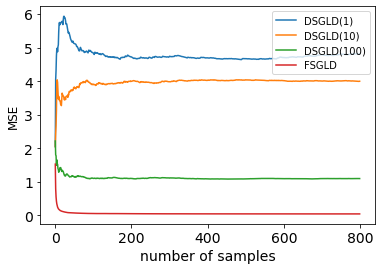

In [12]:
plt.figure(figsize=(6, 4))

plt.plot(np.arange(DS100_CUM.shape[0]), DS100_CUM, label='DSGLD(1)')
plt.plot(np.arange(DS10_CUM.shape[0]), DS10_CUM, label='DSGLD(10)')
plt.plot(np.arange(DS1_CUM.shape[0]), DS1_CUM, label='DSGLD(100)')
plt.plot(np.arange(CG100_CUM.shape[0]), CG100_CUM.flatten(), label='FSGLD')
plt.legend(loc=1, fontsize=10)
plt.ylabel('MSE', fontsize=12)
plt.xlabel('number of samples', fontsize=14)
plt.tick_params(labelsize=14)
plt.savefig('mse_blobs_new2.png')
plt.show()

# Results with SGLD  (for reference only)

In [13]:
Dj = [np.vstack(Dlist)]

In [14]:
theta0 = np.zeros(2,) + 6   # initial param

eps = 1e-06
thin = int(1e02) # 1e02
burn = int(2e04)

SGLD_1 = DSGLD(Dj, eps=eps, n=10, theta0=theta0*0, rounds=100000, iter_per_round=1)   

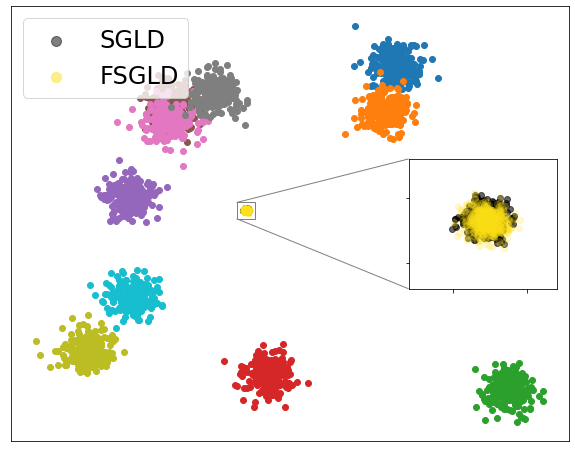

In [15]:

matplotlib.rcParams.update({'font.size': 24})

analytic_mu = np.sum(X, axis=0) / (X.shape[0] + 0.2)
analytic_cov = 1/(X.shape[0] + 0.2) * np.identity(2)
target = np.random.multivariate_normal(analytic_mu, analytic_cov, size=1000)

SGLD_1_MSE = pairwise_distances(SGLD_1[::thin,:], np.reshape(analytic_mu, (1, analytic_mu.shape[0])))
SGLD_1_CUM = np.zeros(SGLD_1_MSE.shape)

f = plt.figure(figsize=(10, 8))
# f = plt.figure()


for i in range(DS100_CUM.shape[0]):
    SGLD_1_CUM[i] = np.mean(SGLD_1_CUM[:(i+1)])

for k in range(K):
    plt.scatter(D[k, :, 0], D[k, :, 1])


plt.gca().set_xticks([]) 
plt.gca().set_yticks([]) 

plt.scatter(SGLD_1[burn::thin,0], SGLD_1[burn::thin, 1], color='k', marker='o', s=16, alpha=0.5, label='SGLD')
# plt.scatter(target[:,0], target[:, 1], color='b')
plt.scatter(CG_1[burn::thin, 0], CG_1[burn::thin, 1], color='#ffe119', marker='o', s=16, alpha=0.5 , label='FSGLD')
plt.legend(loc='upper left', markerscale=2.5)

plt.tick_params()#(labelsize=12)


ax = f.axes[0]
axins = zoomed_inset_axes(ax,  8, loc='center right')
axins.scatter(SGLD_1[burn::thin,0], SGLD_1[burn::thin, 1], color='k', marker='o', alpha=0.6, label='SGLD')
axins.scatter(CG_1[burn::thin,0], CG_1[burn::thin, 1], color='#ffe119', marker='o', alpha=0.2, label='FSGLD')
# axins.legend()



axins.set_ylim([-0.6, -0.1])
axins.set_xlim([-1.9, -1.4])
axins.set_yticklabels([])
axins.set_xticklabels([])

mark_inset(ax, axins, loc1=3, loc2=2, fc="none", ec="0.5")


plt.savefig('blob_sgld_rect_24.pdf', bbox_inches='tight')
plt.show(block=False)
np.random.seed(123)

# Quantifying $\epsilon_s^2$'s and $\gamma_s^2$'s

In [ ]:
c1, c2 = np.meshgrid(np.linspace(-7,7,100), np.linspace(-7,7,100))
Z = c1
es = []
for s in range(K):
    Xs = Dlist[s]
    m = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            theta = np.array([c1[i, j], c2[i, j]])
            aux = 0
            for l in range(Xs.shape[0]):
                 aux += ((grad_log_lik(Xs, theta)/Xs.shape[0] - grad_log_lik(Xs[l, :], theta)) ** 2).sum()
            aux = aux/Xs.shape[0]
            if aux > m:
                m = aux
                max_idx = [i, j]
    print(f'FSGLD epsilon squared for shard {s}: {aux}, idx={max_idx}')
    es.append(aux)

c1, c2 = np.meshgrid(np.linspace(-7,7,100), np.linspace(-7,7,100))
Z = c1
gs = []
for s in range(K):
    Xs = Dlist[s]
    m = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            theta = np.array([c1[i, j], c2[i, j]])
            aux = 0
            for l in range(Xs.shape[0]):
                 aux += (grad_log_lik(Xs[l, :], theta) ** 2).sum()
            aux = aux/Xs.shape[0]
            if aux > m:
                m = aux
                max_idx = [i, j]
    print(f'DSGLD gamma squared for shard {s}: {aux}, idx={max_idx}')
    gs.append(aux)
    
es = np.array(es)
gs = np.array(gs)




# plt.plot(range(es.shape[0]), es)
# plt.plot(range(es.shape[0]), gs)
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['xtick.major.pad']='12'
matplotlib.rcParams['ytick.major.pad']='12'

plt.rcParams["mathtext.fontset"] = "cm"
labels = [f'$\gamma_{i}$' for i in range(K)];
# f = plt.figure()
f = plt.figure(figsize=(6, 4))

barWidth = 1
r1 = np.array( (np.arange(len(es)) + 1) * 11.0)
# for i in range(r1.shape[0]):
#     r1[i] += 1.0
    
r2 = np.array([x + barWidth + 3 for x in r1])
plt.bar(r1, es, width=barWidth*3.5, label='FSGLD')
plt.bar(r2, gs, width=barWidth*3.5, label='DSGLD')
ax  = f.axes[0]

ticks = [r1[int(i/2)] if i%2==0 else r2[int((i-1)/2)] for i in range(2*K)]
labels = [f'$\epsilon_{int(i/2)}^2$' if i%2==0 else f'$\gamma_{int((i-1)/2)}^2$' for i in range(2*K)];

ax.set_xticks(ticks)
ax.set_xticklabels(labels, fontsize=12)

ax.set_yticks([0, 300, 600, 900, 1200])
ax.set_yticklabels([0, 300, 600, 900, 1200], fontsize=12)
plt.legend(loc='upper left', fontsize=16)


plt.savefig('gamma_epsilon_20.pdf', bbox_inches='tight')
